## Лабораторная работа №5 
###  По предмету "методы, средства и технологии мультимедиа"
#### Выполнил: Стрыгин Д.Д. 
#### Группа: М8О-406Б-19

#### Лабораторную можно разделить на две части. Первая часть - предобработка данных. Её я выполнял на локальной машине, поэтому выводы ячейк не будут видны, однако код в них я подробнее опишу в комментариях

In [1]:
import os
from tqdm import tqdm
from glob import glob
from PIL import Image
import csv
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMGH = 720
IMGW = 1280
DATA_IMG_TRAIN = 'images/train/'
DATA_IMG_VAL = 'images/val/'
DATA_LBL_TRAIN = 'labels/train/'
DATA_LBL_VAL = 'labels/val/'

Изначально было необходимо перевести данные о разметке изображений в формат, требуемый для работы с YOLO. Для этого я распарсил train.csv содержащий необходимую информацию на файлы, содержащие координаты меток из датасета

In [ ]:
with open('train.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='"')    
    total = 0
    for row in spamreader:
        if (row[0] == '0'):
            total += 1
            rd = row[5]
            num = ''
            totext = ''            
            pst = ''
            wrt_n = 0
            for lit in rd:                
                if (lit in ['0','1','2','3','4','5','6','7','8','9']):
                    num += lit
                else:
                    if (num != ''):
                        if (wrt_n == 0):
                            totext += '0 '
                        wrt_n += 1
                        
                        if (wrt_n % 2 == 1):
                            num = str(int(num) / IMGW)
                        else:
                            num = str(int(num) / IMGH)                            
                        totext += num + ' '                                              
                    num = ''                
                if (lit == ',' and pst == '}'):                     
                    totext += '\n' 
                    wrt_n = 0                
                pst = lit
            print(totext)
            with open(DATA_LBL_TRAIN + row[2] + '.txt', 'w') as f:
                f.write(totext)                  
    print(total)

Затем необходимо было облегчить датасет, удалив из него изображения, не содержащие меток.

In [ ]:
for name in tqdm(os.listdir(DATA_LBL_TRAIN[:-1])):
    to_rm = False
    with open(DATA_LBL_TRAIN + name, 'r') as f:
        fcon = f.read()
        if(fcon == ''):
            to_rm = True
    if(to_rm):
        os.remove(DATA_LBL_TRAIN + name)
        os.remove(DATA_IMG_TRAIN + name[: -4] + '.jpg')

Затем я перемешал и разбил выборку на треннировочную и валидационную в соотношении 80:20.

In [ ]:
train_images = sorted(glob(f"{DATA_IMG_TRAIN}*"))
train_labels = sorted(glob(f"{DATA_LBL_TRAIN}*"))
lst = list(zip(train_images, train_labels))
random.shuffle(lst)
train_images, train_labels = zip(*lst)
for i in range(int(len(train_images) * 0.2)):
    os.replace(train_images[i], DATA_IMG_VAL + train_images[i].split('\\')[1])
    os.replace(train_labels[i], DATA_LBL_VAL + train_labels[i].split('\\')[1])

####Здесь начинается вторая часть, связанная с обучением модели. Её я выполнял на колабе. Сначала я скачиваю YOLOV5.

In [3]:
#!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-163-g016e046 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.4/78.2 GB disk)


####Для передачи датасета модели был создан yaml файл со следующим содержанием:
train: /content/drive/MyDrive/datasets/reef_video_0/images/train  
val: /content/drive/MyDrive/datasets/reef_video_0/images/val

nc: 1

names: ['starfish']

####Далее обучаю модель

In [6]:
!python3 train.py --img 1280 --batch 16 --epochs 12 --data /content/drive/MyDrive/datasets/reef_video_0/reef.yaml --weights yolov5s.pt --device 0 --hyp data/hyps/hyp.scratch-low.yaml


train: weights=yolov5s.pt, cfg=, data=/content/drive/MyDrive/datasets/reef_video_0/reef.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=12, batch_size=16, imgsz=1280, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
requirements: /content/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-163-g016e046 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.

В результате обучения в течении 12 эпох была получена модель с высокими значениями precision и recall, что видно по графикам

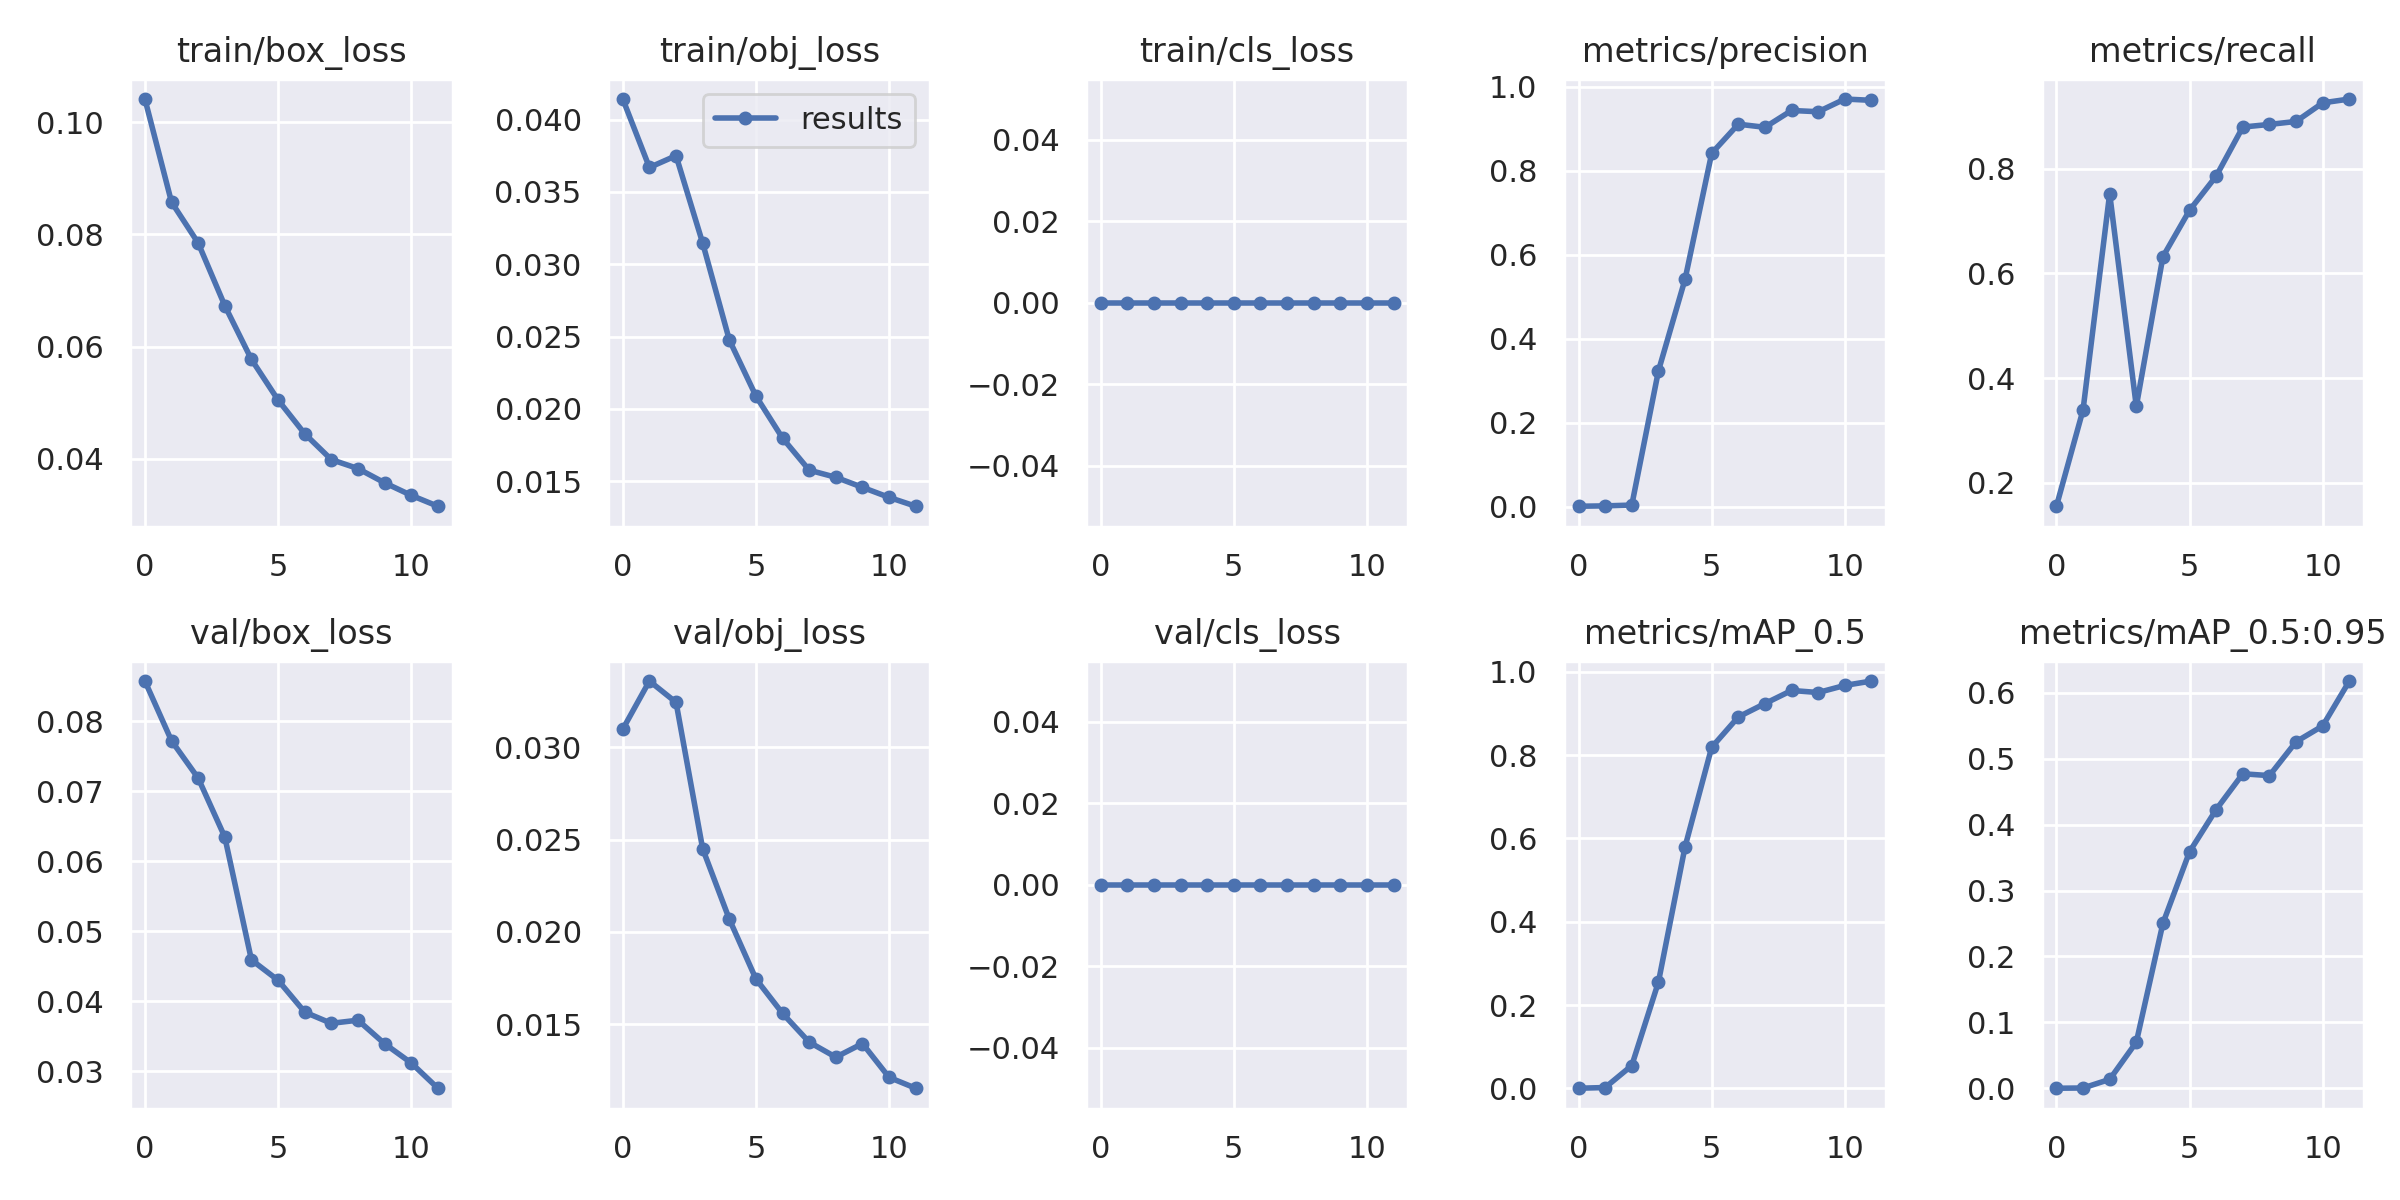

In [11]:
display.Image(filename='/content/yolov5/runs/train/exp3/results.png', width=1000)

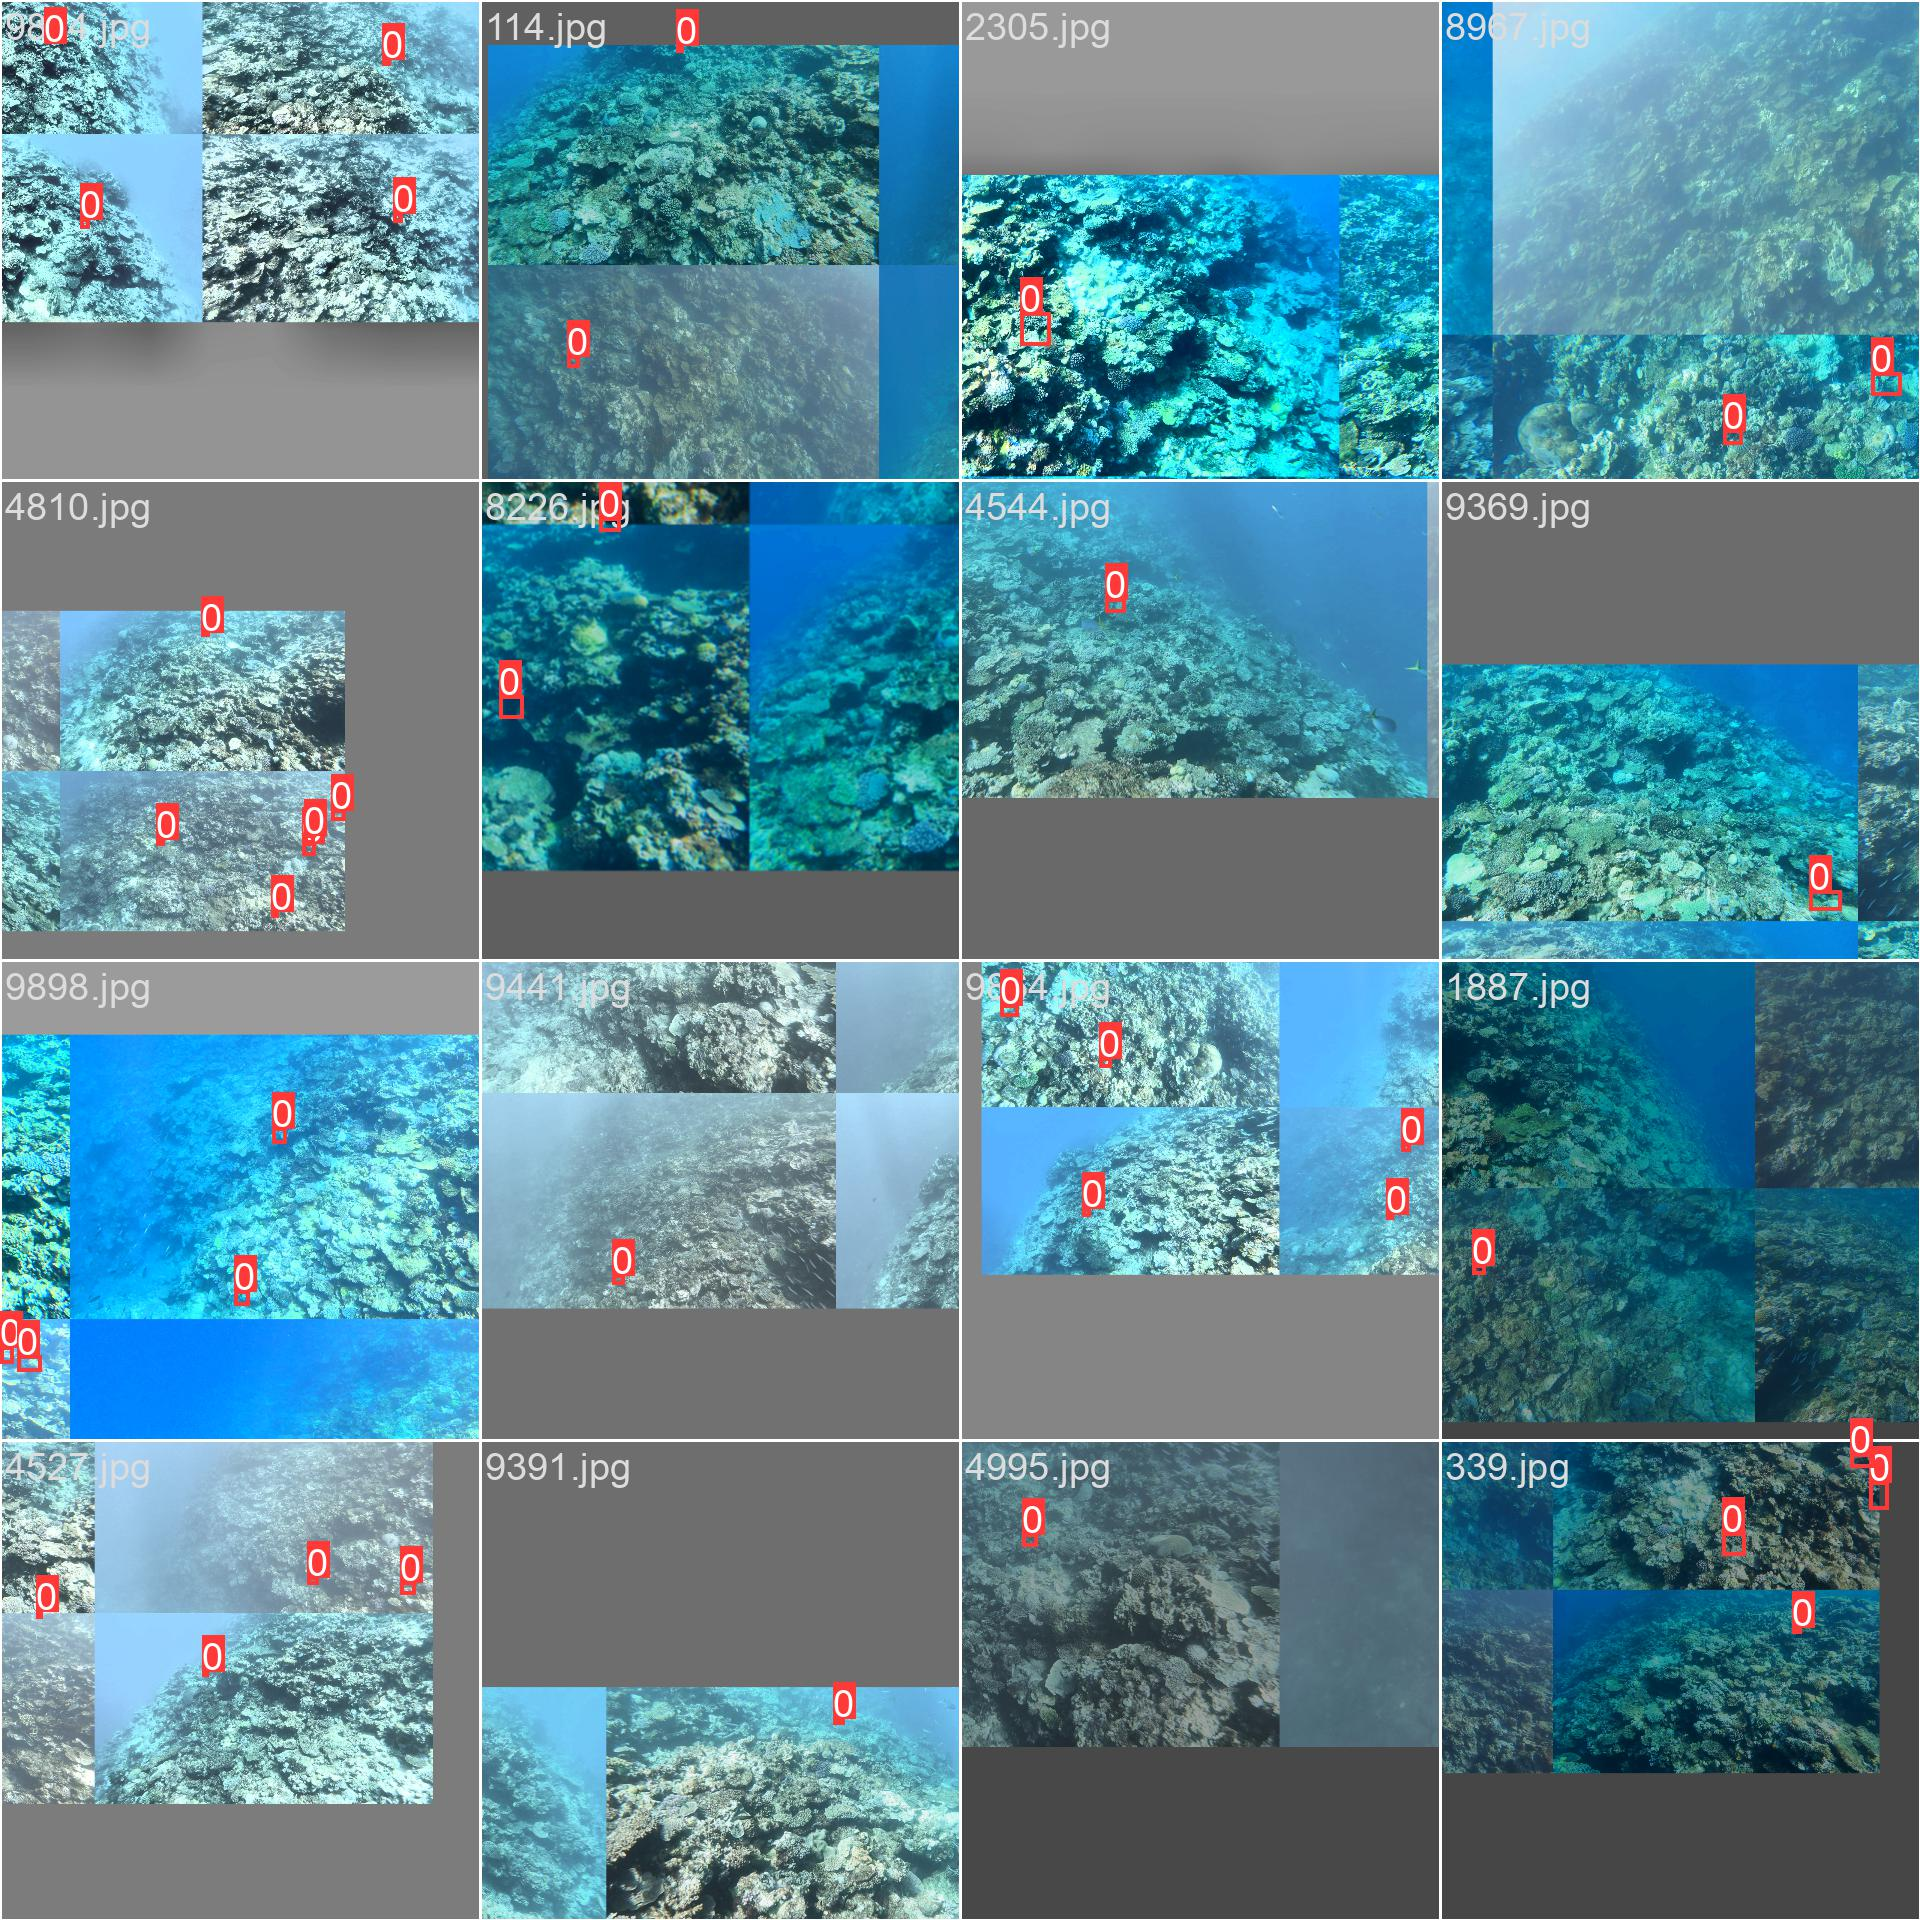

In [13]:
display.Image(filename='/content/yolov5/runs/train/exp3/train_batch1.jpg', width=700)

Визуально сверяем предсказание с реальной разметкой

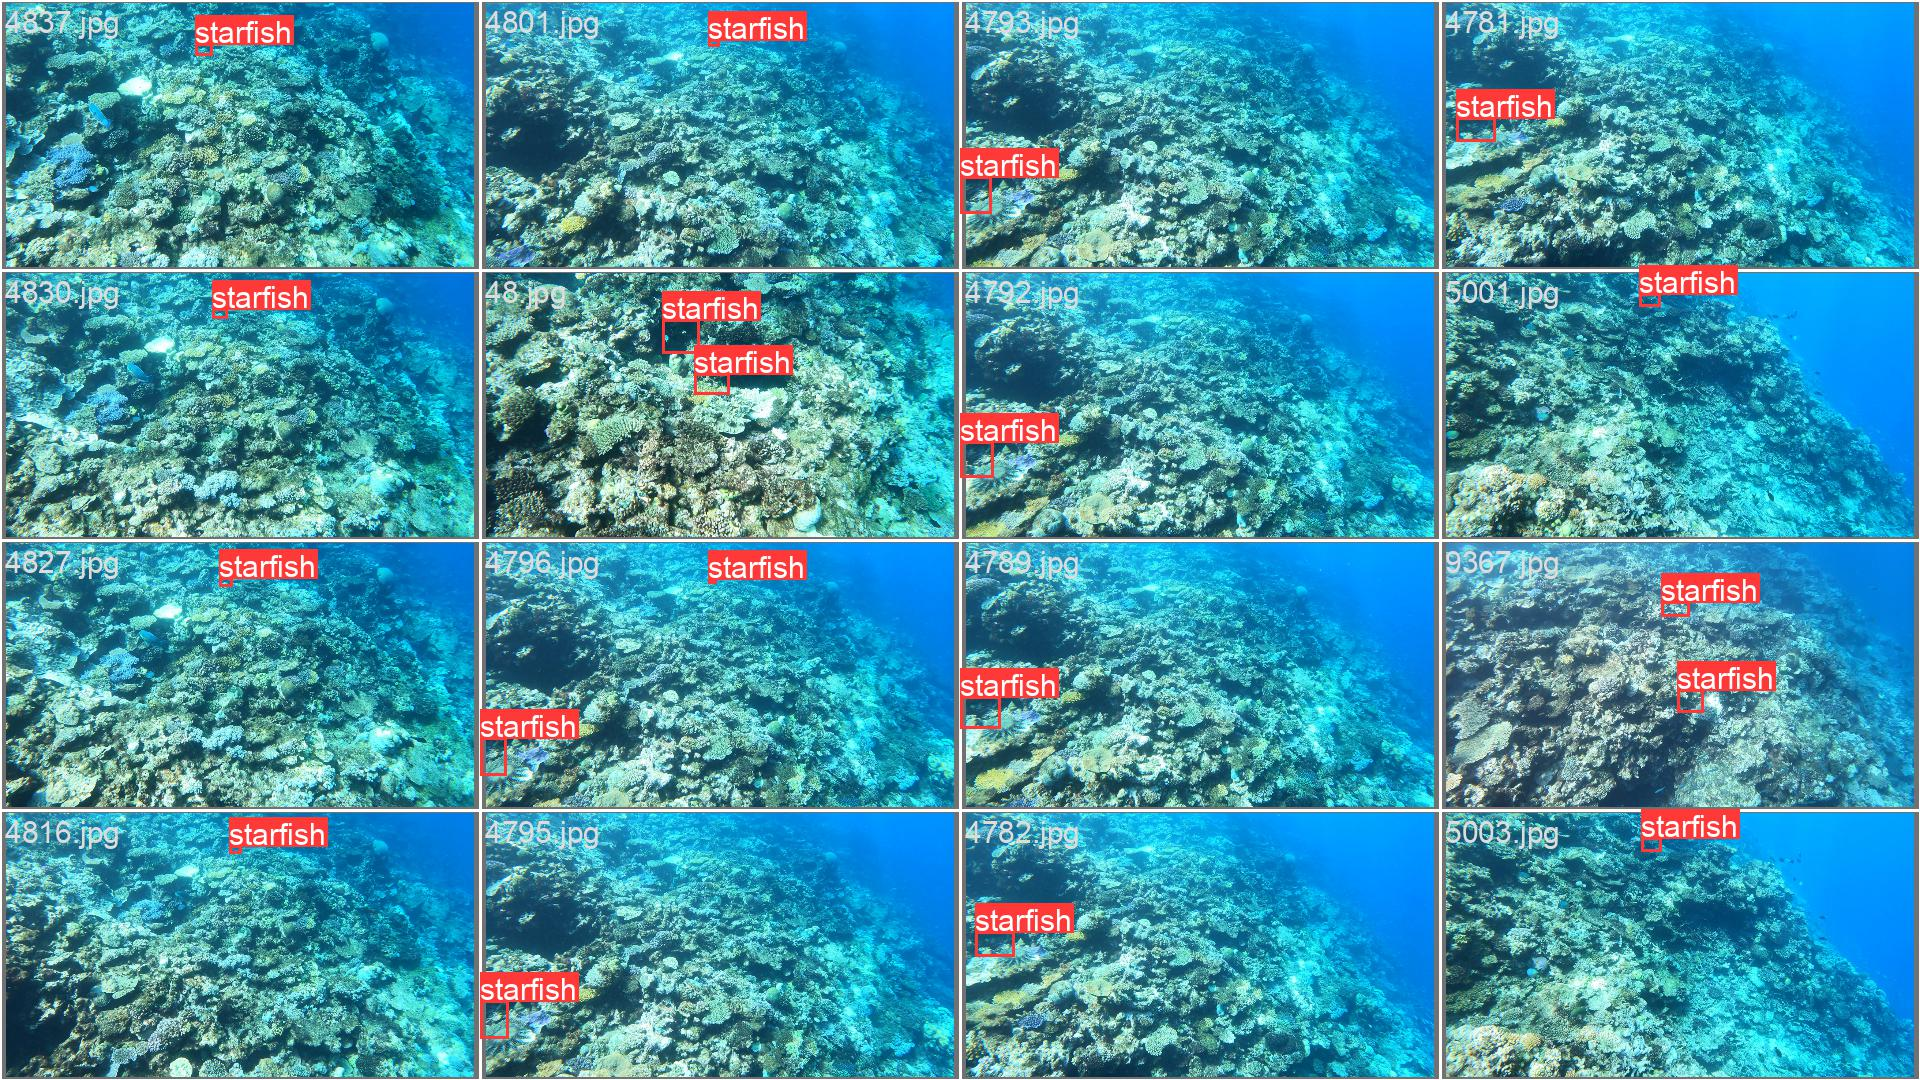

In [14]:
display.Image(filename='/content/yolov5/runs/train/exp3/val_batch2_labels.jpg', width=1000)

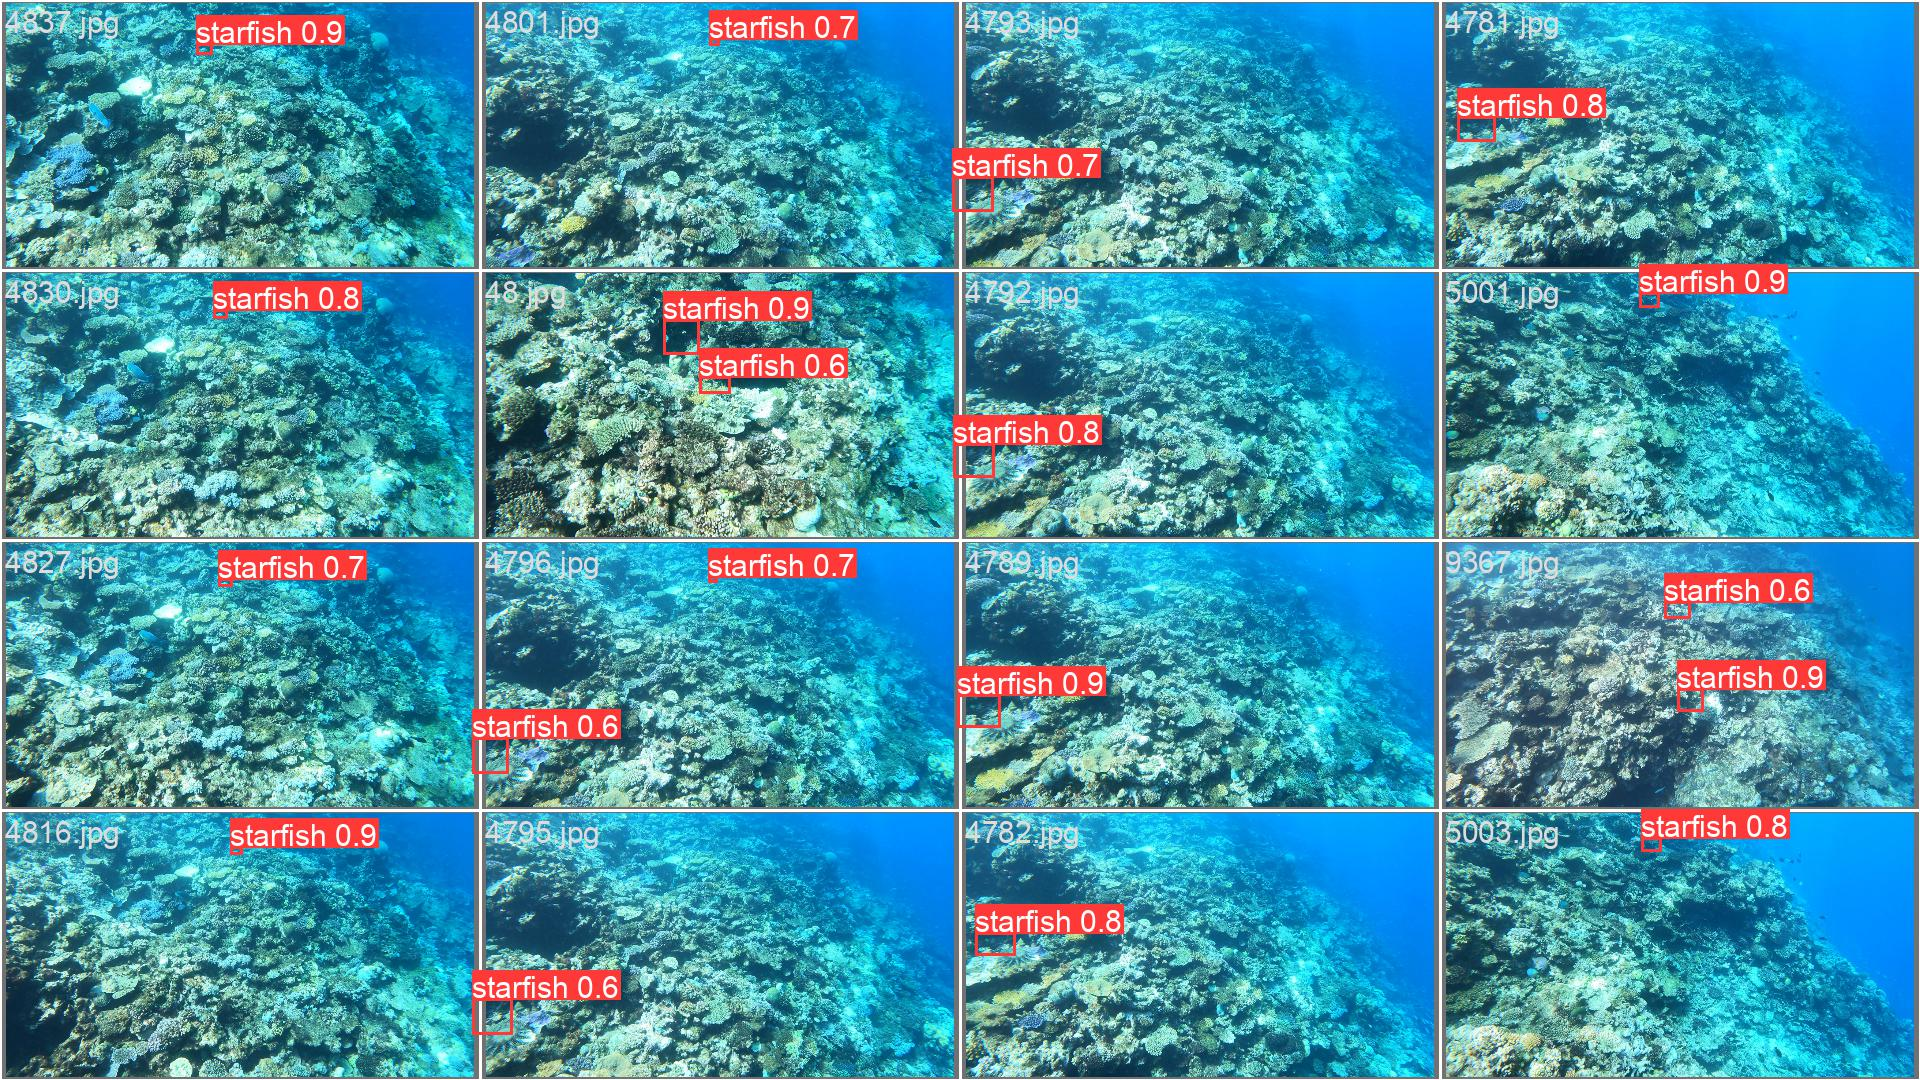

In [15]:
display.Image(filename='/content/yolov5/runs/train/exp3/val_batch2_pred.jpg', width=1000)

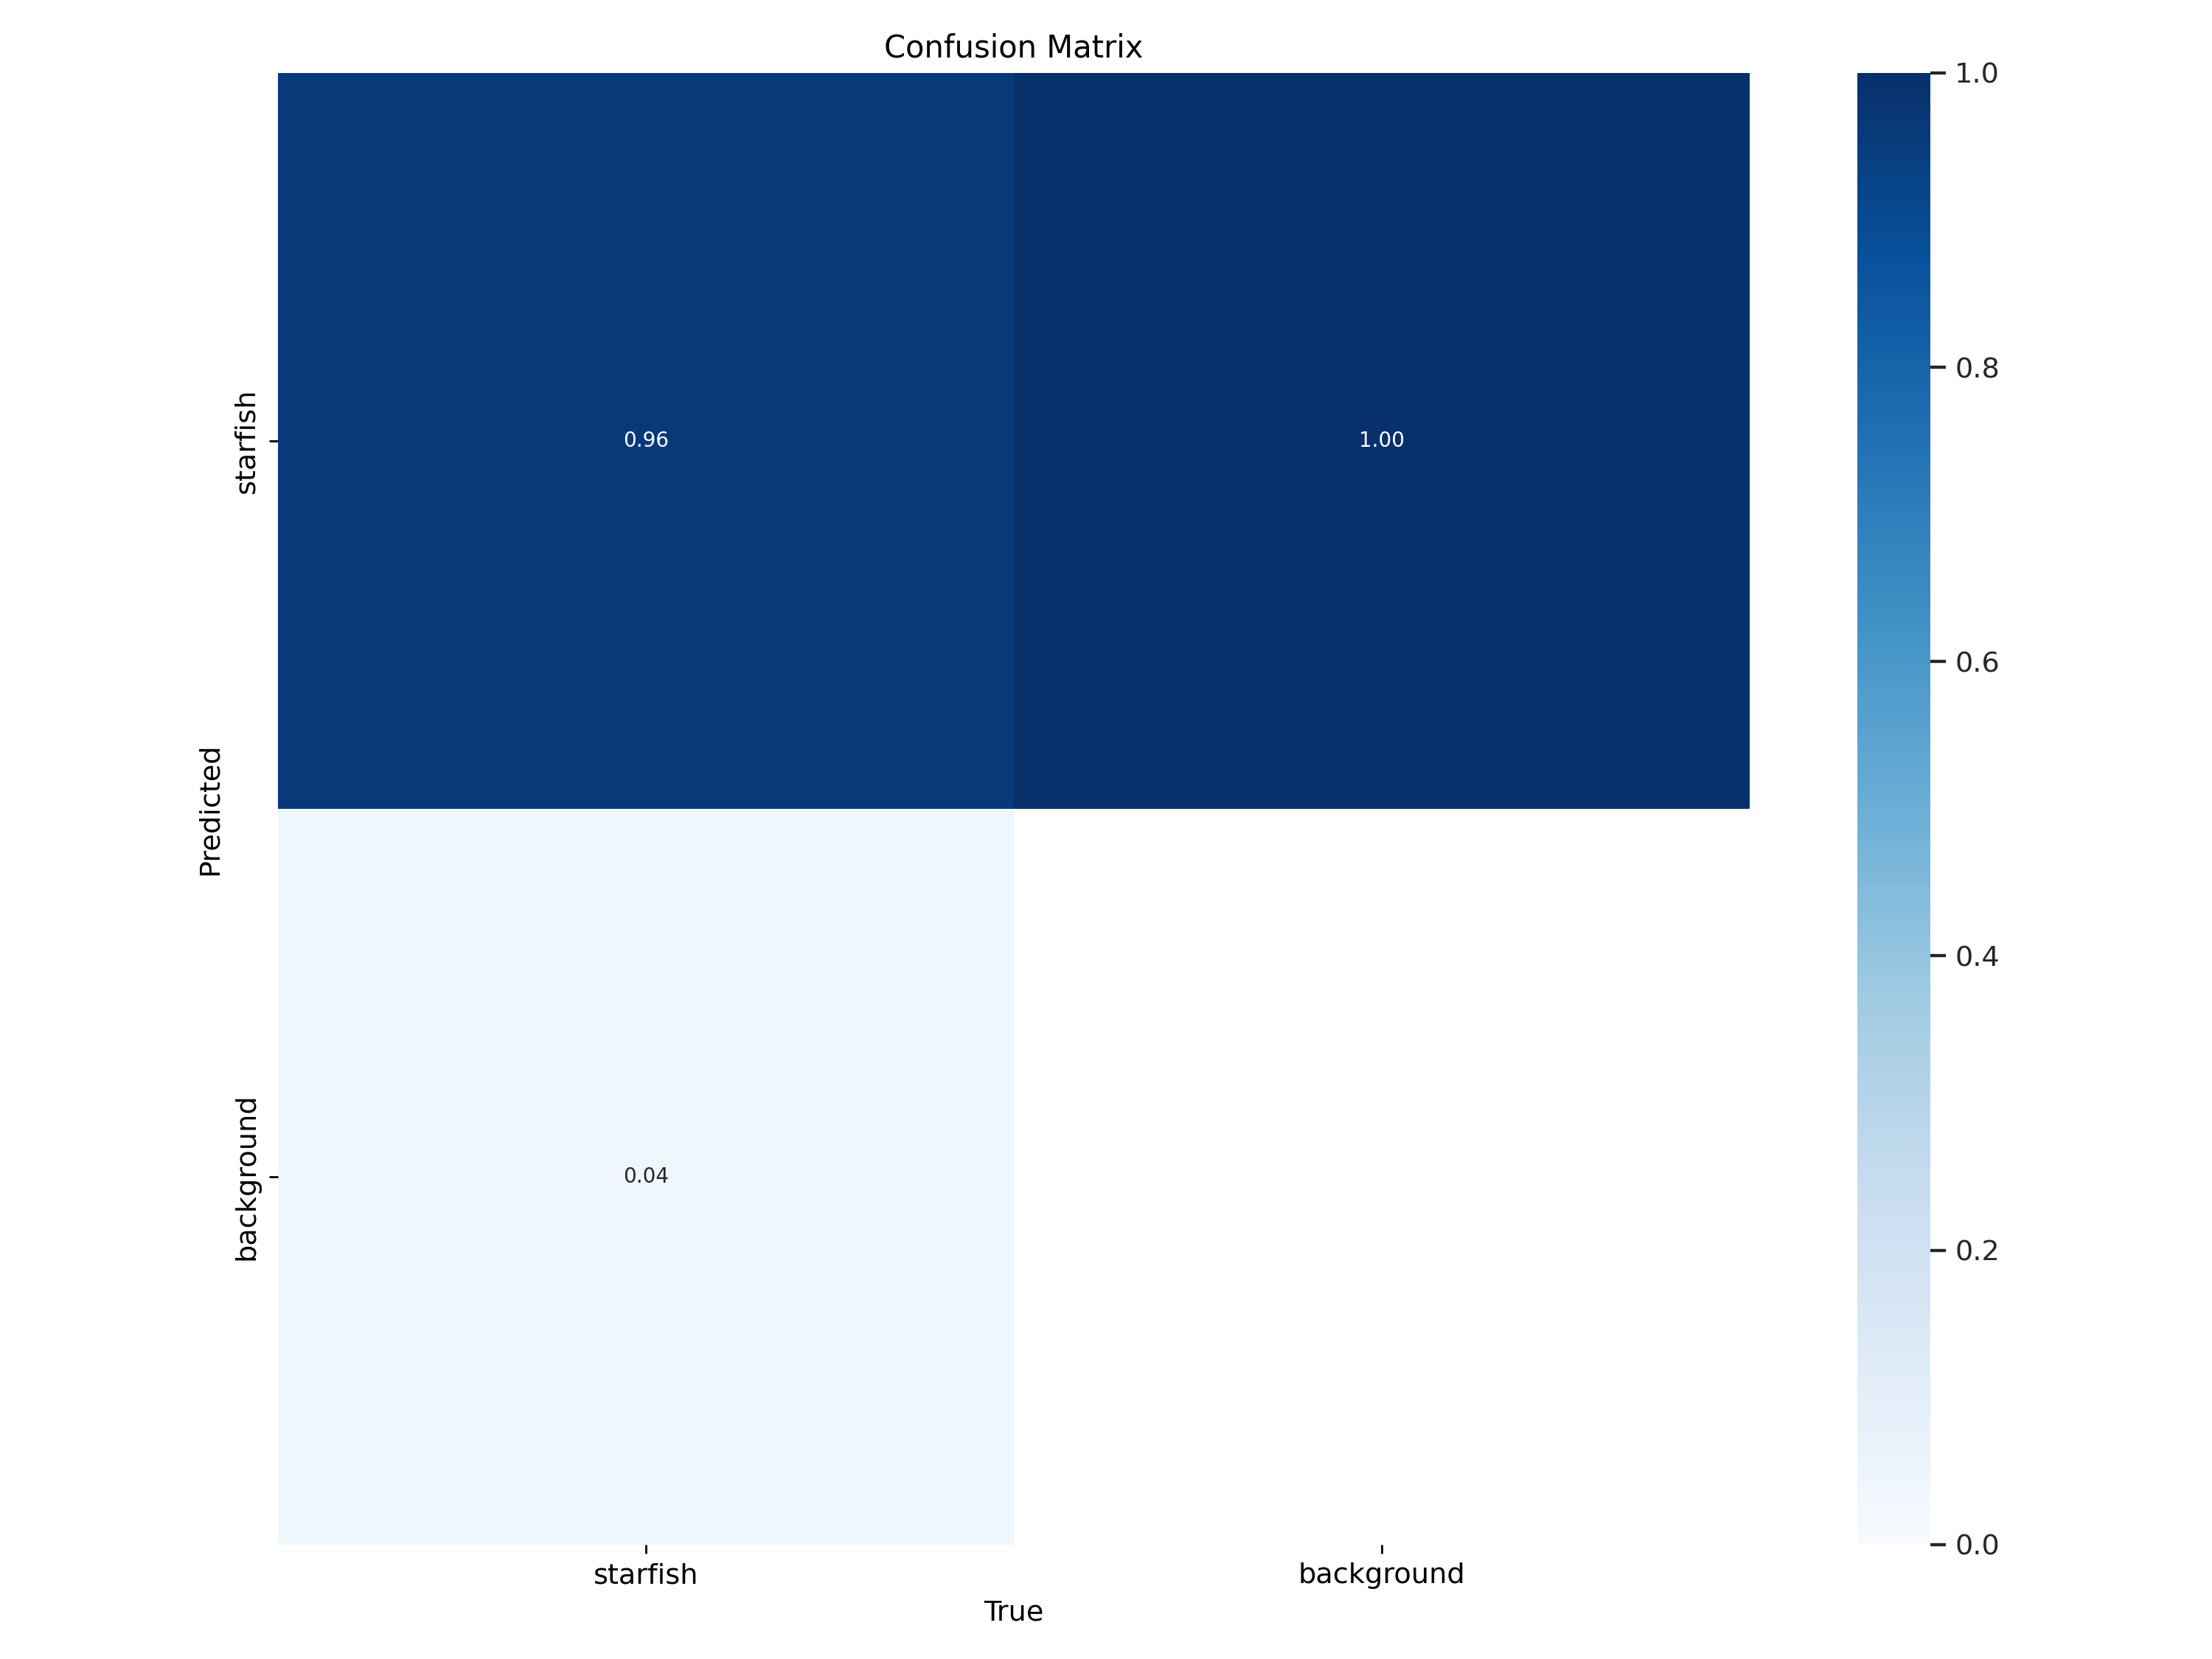

In [16]:
display.Image(filename='/content/yolov5/runs/train/exp3/confusion_matrix.png', width=700)

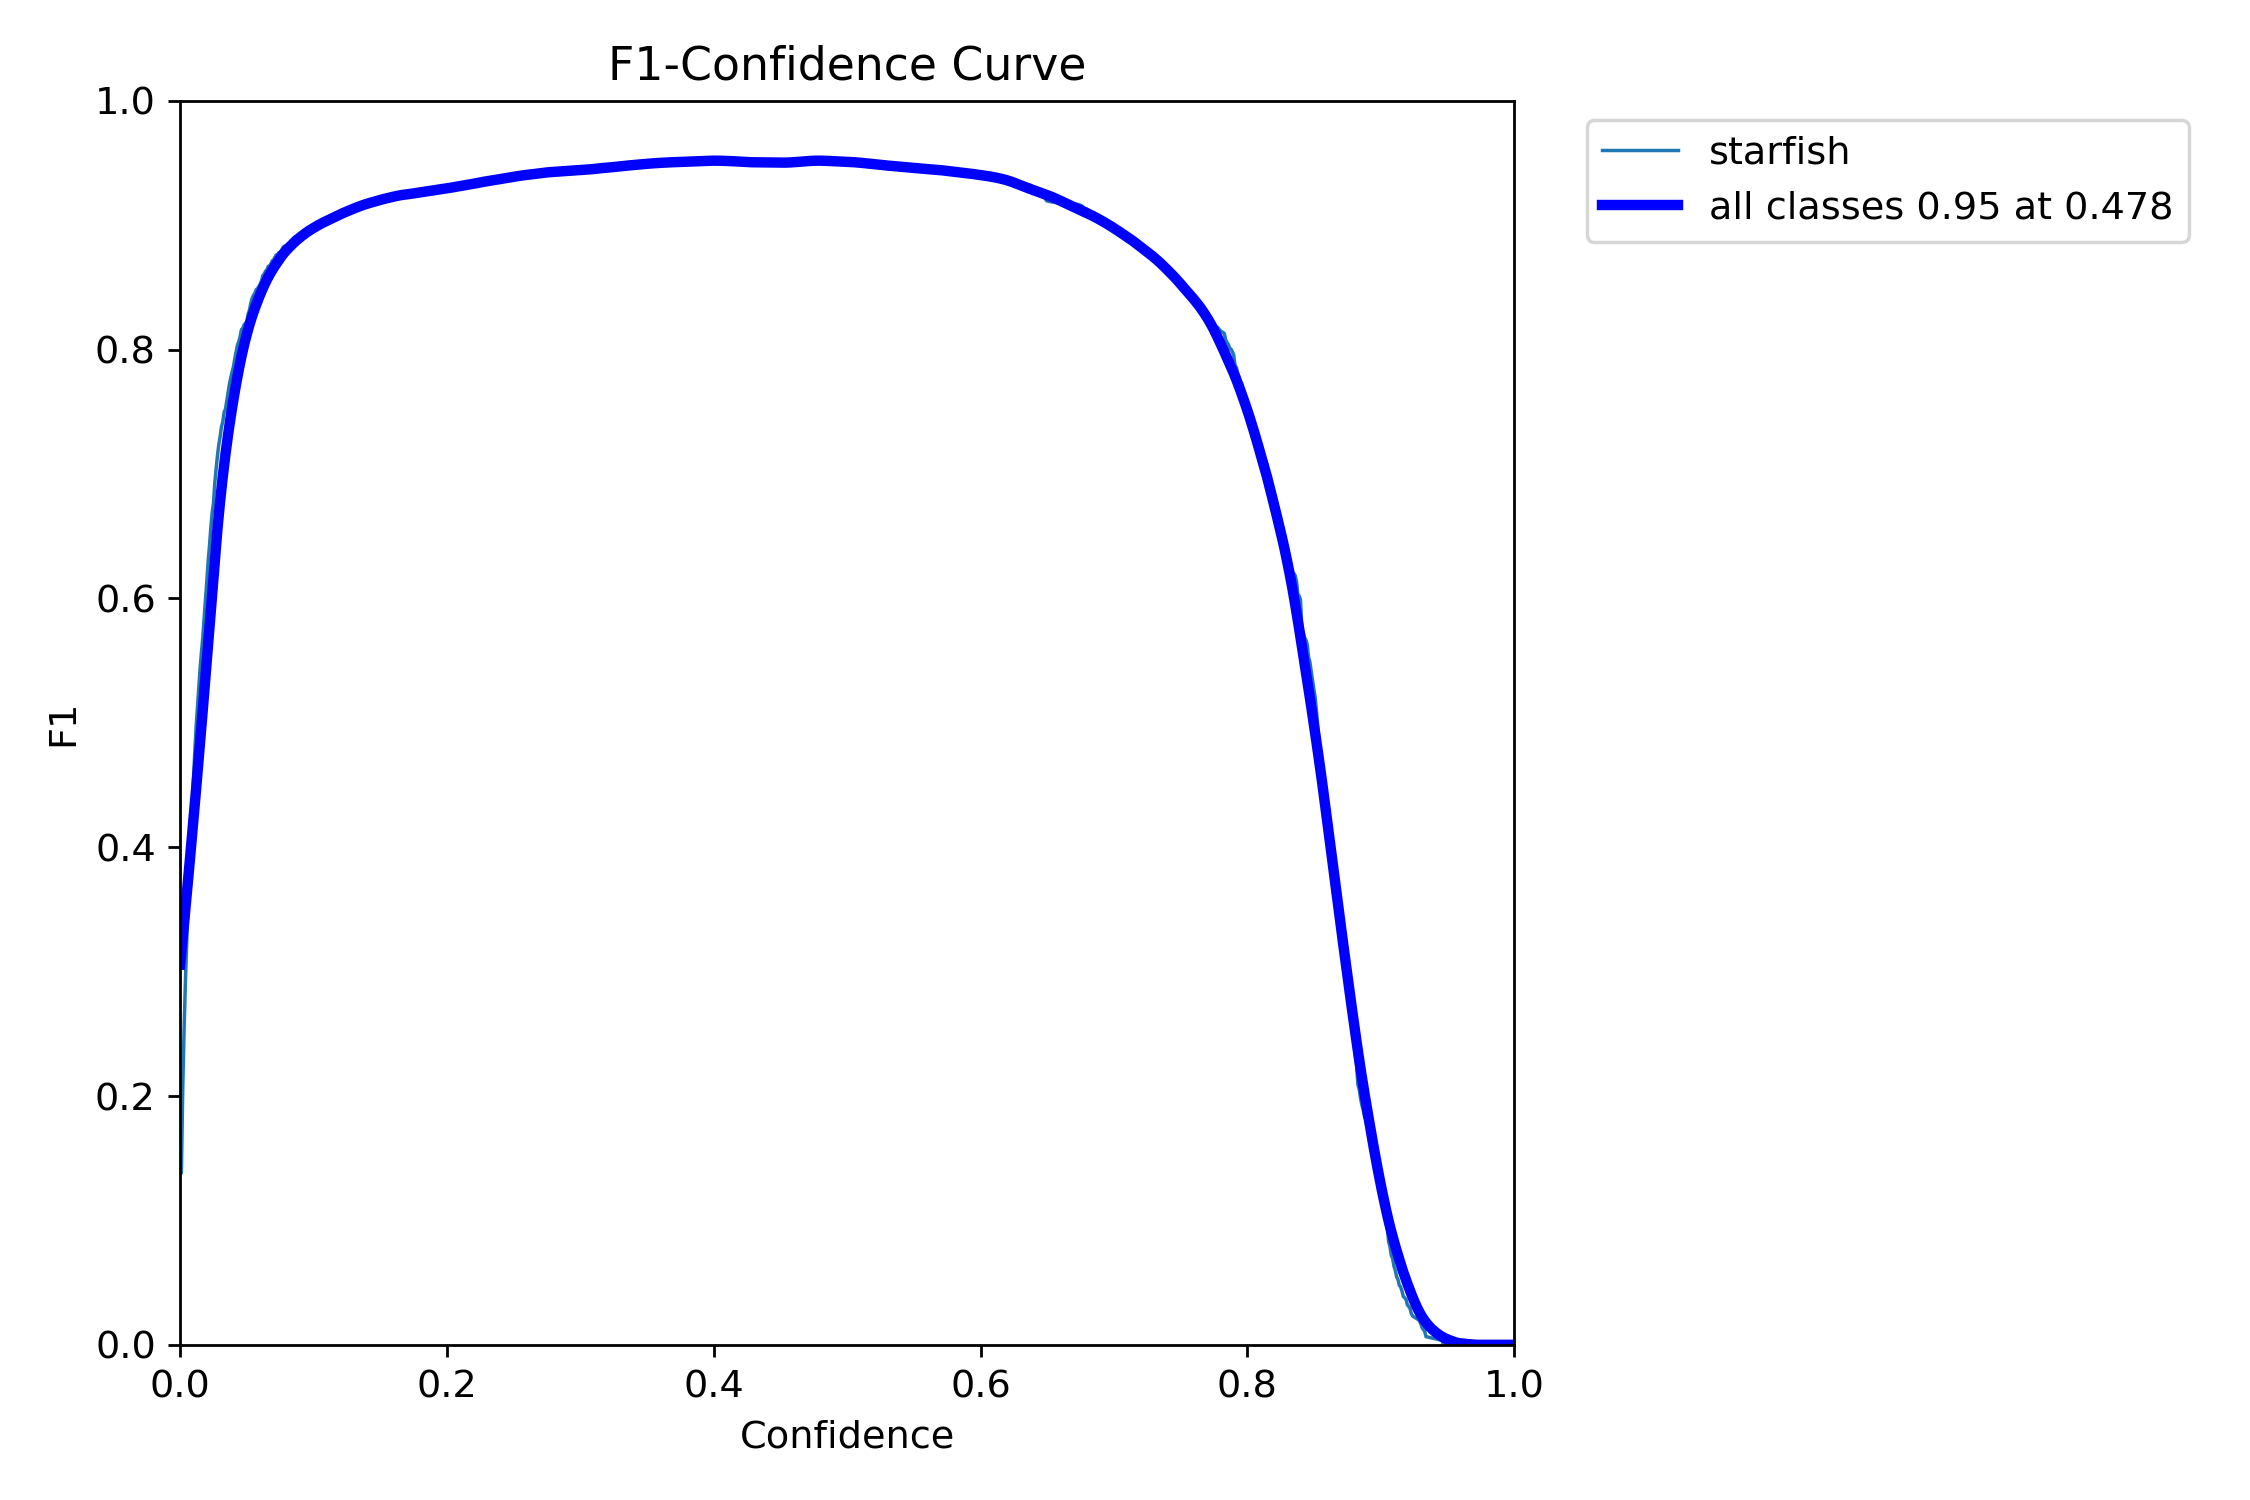

In [17]:
display.Image(filename='/content/yolov5/runs/train/exp3/F1_curve.png', width=700)

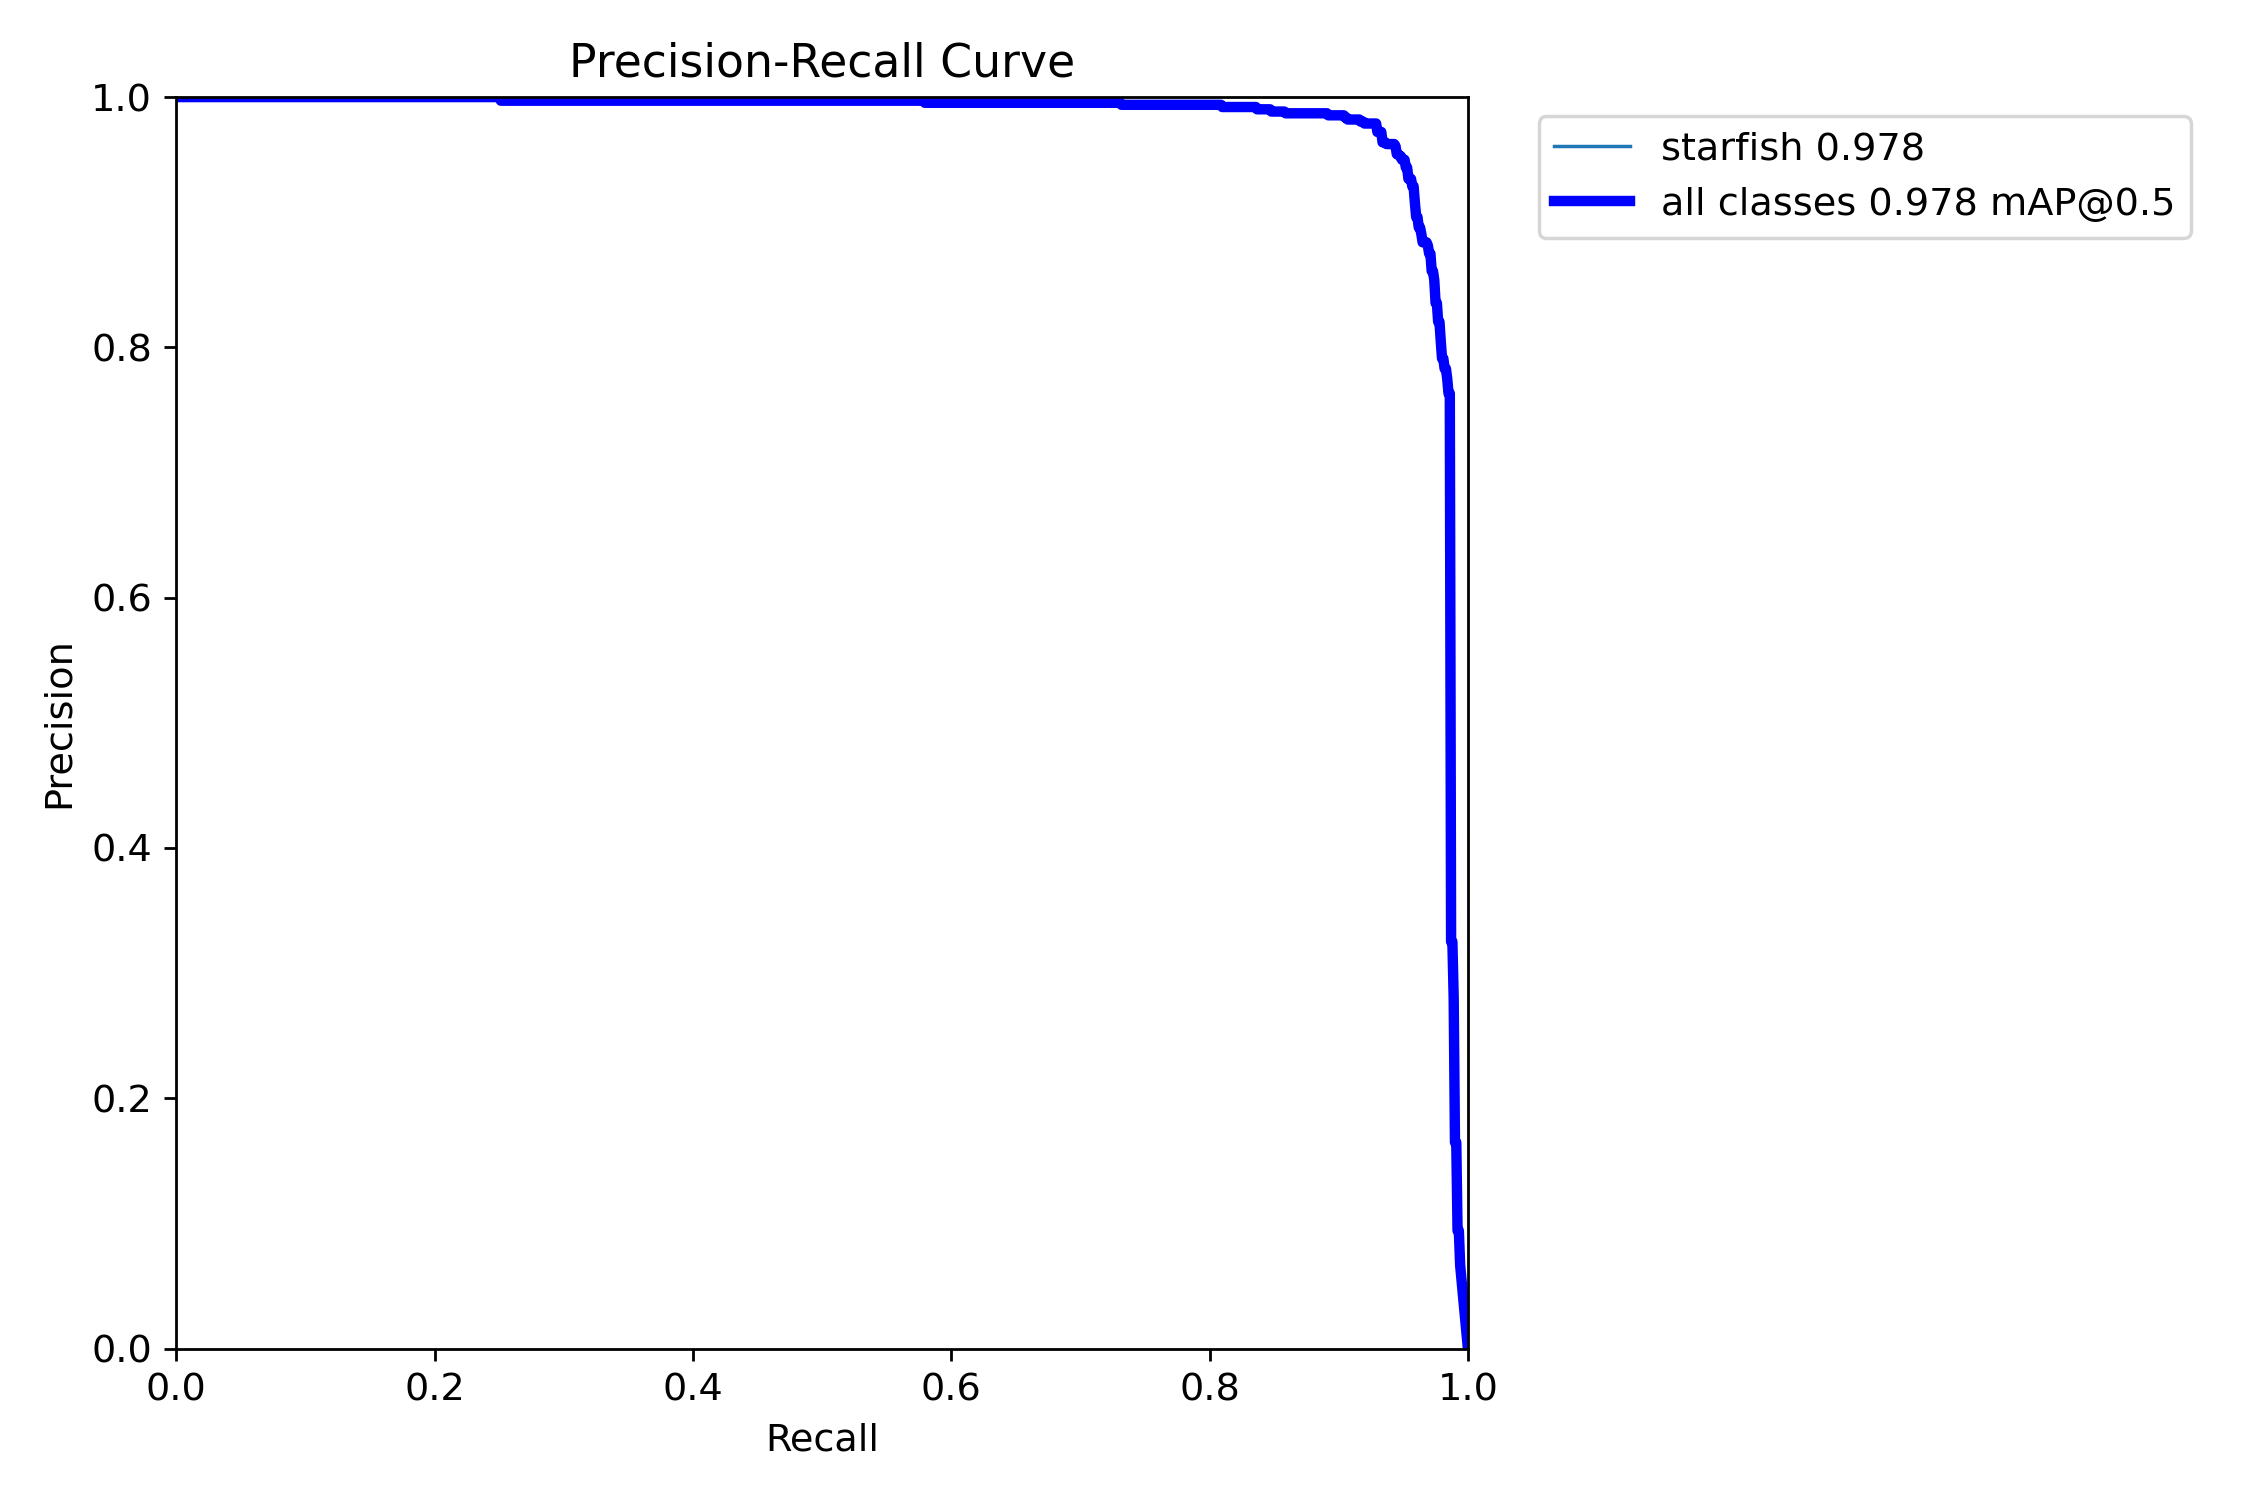

In [18]:
display.Image(filename='/content/yolov5/runs/train/exp3/PR_curve.png', width=700)

### Вывод
В ходе обучения была получана модель, хорошо справляющаяся с задачей детекции терновых венцов, что видно как по метрикам (presision/recall), так и по примеру ее работы с вылидационными данными.